## transfer learning with tensorflow part 1: feature extraction

Transfer learning is leveraging a working model's existings architecture and learned patterns for our own problem.

there are two benefits:
1. can leverage an existing neural network architecture proven to work on problems similar to our own
2. can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# are we using a gpu?
!nvidia-smi

Sun Jul 30 22:03:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# get data (10% of 10 food classes from Food101)
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file
with zipfile.ZipFile("10_food_classes_10_percent.zip") as zip_ref:
  zip_ref.extractall()

--2023-07-30 22:03:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.1MB/s    in 4.7s    

2023-07-30 22:04:05 (34.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# how many images in each folder
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 10 directori

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whils our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping amodel from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

*Note:* You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameters we've created above is only one option

## Creating models using TensorFlow Hub

In the past we've used tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are goinge to come fron TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [9]:
# let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretarained model and save it as a Keras layer:
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned pattern
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub feature Extraction model

In [10]:
train_data_10_percent.num_classes

10

In [11]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [12]:
# compile our resnet model
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230730-220419
Epoch 1/5
24/24 [==============================] - 26s 605ms/step - loss: 1.9005 - accuracy: 0.3547 - val_loss: 1.2089 - val_accuracy: 0.6120
Epoch 2/5
24/24 [==============================] - 12s 511ms/step - loss: 0.9112 - accuracy: 0.7347 - val_loss: 0.8527 - val_accuracy: 0.7336
Epoch 3/5
24/24 [==============================] - 11s 461ms/step - loss: 0.6474 - accuracy: 0.8133 - val_loss: 0.7794 - val_accuracy: 0.7456
Epoch 4/5
24/24 [==============================] - 11s 460ms/step - loss: 0.4848 - accuracy: 0.8760 - val_loss: 0.7086 - val_accuracy: 0.7612
Epoch 5/5
24/24 [==============================] - 11s 465ms/step - loss: 0.3929 - accuracy: 0.9013 - val_loss: 0.6734 - val_accuracy: 0.7772


That's is incredible, our transfer learning feature extractor out performed all of the previous models we built by hand... substantially. And in a quicker training time and with only 10% of the training examples

In [15]:
import matplotlib.pyplot as plt
# Let's create a function to plot our loss curves...
# tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  returns reparate loss curves for training and validation metrics.

  Args:
    history: TensorFlow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics
  """

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, history.history["loss"], label="loss")
  plt.plot(epochs, history.history["val_loss"], label="val_loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs, history.history["accuracy"], label="accuracy")
  plt.plot(epochs, history.history["val_accuracy"], label="val_accuracy")
  plt.legend()

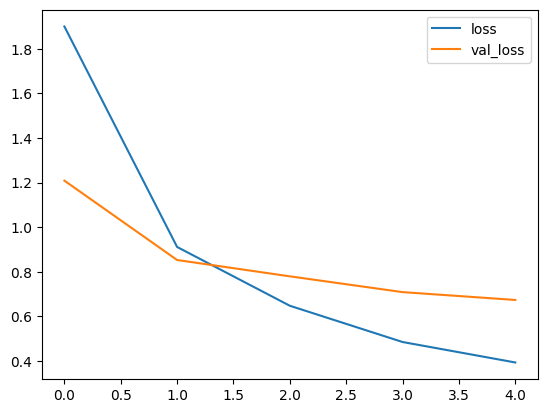

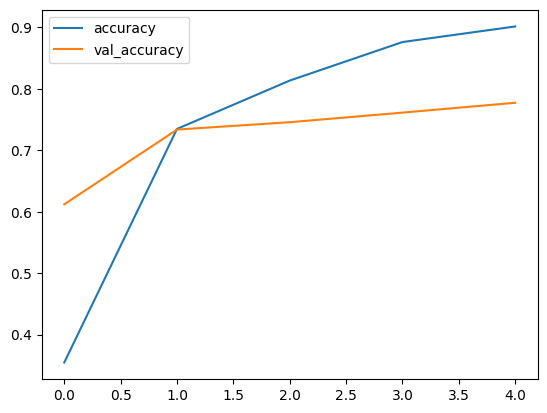

In [16]:
plot_loss_curves(resnet_history)

In [17]:
# Let's create a function to plot our loss curves...
# tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  returns reparate loss curves for training and validation metrics.

  Args:
    history: TensorFlow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("eEpochs")
  plt.legend()


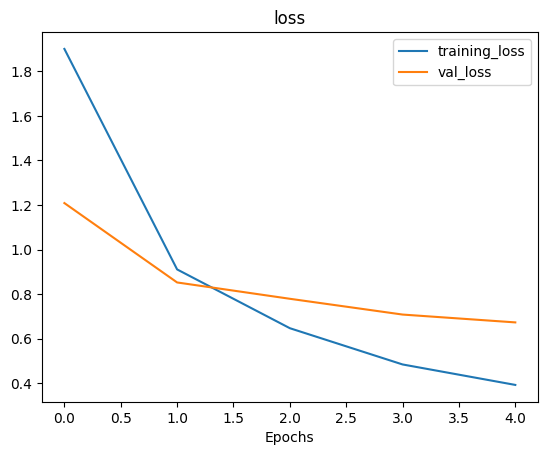

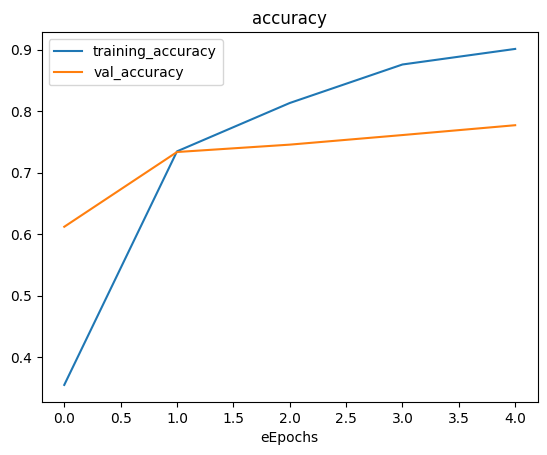

In [18]:
plot_loss_curves(resnet_history)

### Creating andd testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [19]:
# create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# compile the model
efficientnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230730-220600
Epoch 1/5
24/24 [==============================] - 23s 542ms/step - loss: 1.9181 - accuracy: 0.3800 - val_loss: 1.3635 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 11s 451ms/step - loss: 1.0994 - accuracy: 0.7707 - val_loss: 0.8977 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 10s 443ms/step - loss: 0.7686 - accuracy: 0.8320 - val_loss: 0.7139 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 10s 440ms/step - loss: 0.6167 - accuracy: 0.8667 - val_loss: 0.6202 - val_accuracy: 0.8504
Epoch 5/5
24/24 [==============================] - 10s 433ms/step - loss: 0.5204 - accuracy: 0.8787 - val_loss: 0.5633 - val_accuracy: 0.8552


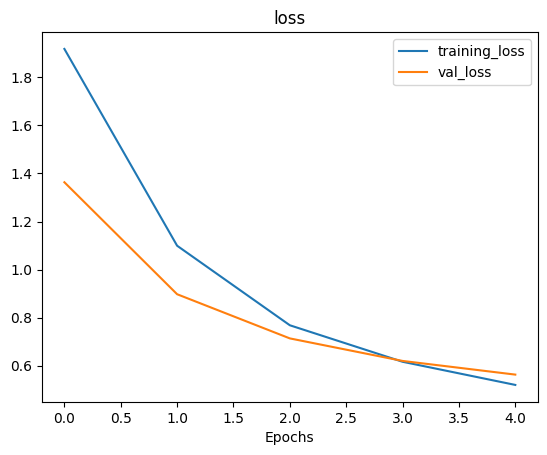

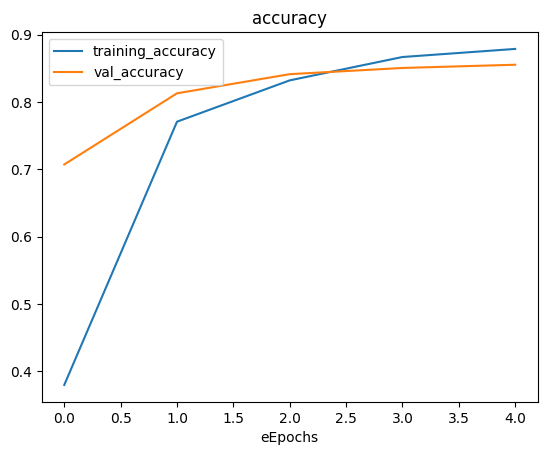

In [20]:
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever
(e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet and adjust the output layer ofr your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layer (including new output layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to Tensorboard.dev, your experiments eare public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [24]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2023-07-30 22:07:14.477998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   QRK-LQY-XPG



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

Our tensorboard experiments are uploaded publicly here: https://tensorboard.dev/experiment/slSGD3gLSrWzRVSb45iRIw/

In [25]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-07-30 22:08:58.795111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/8vMAAl2MRqmIWBKreJPXrg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   8vMAAl2MRqmIWBKreJPXrg
	Created              2023-07-30 22:08:52 (8 seconds ago)
	Updated              2023-07-30 22:08:55 (5 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
https://tensorboard.dev/experiment/O7pyIoI0QiysPxrxghbVeA/
	Name                 EfficientNetB0 vs. ResNet50V2 vs MobileNetV2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   O7pyIoI0QiysPxrxghbVeA
	Created              2023-07-30 20:52:04 (1 hour ago)
	Upda

In [26]:
# Delete an experiment
#!tensorboard dev delete --experiment_id slSGD3gLSrWzRVSb45iRIw

In [27]:
# Confirm the deletion by re-checking what experiments you have laeft
!tensorboard dev list

2023-07-30 22:09:03.140948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/8vMAAl2MRqmIWBKreJPXrg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   8vMAAl2MRqmIWBKreJPXrg
	Created              2023-07-30 22:08:52 (13 seconds ago)
	Updated              2023-07-30 22:08:55 (10 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
https://tensorboard.dev/experiment/O7pyIoI0QiysPxrxghbVeA/
	Name                 EfficientNetB0 vs. ResNet50V2 vs MobileNetV2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   O7pyIoI0QiysPxrxghbVeA
	Created              2023-07-30 20:52:04 (1 hour ago)
	Up

In [28]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [29]:
feature_extractor_layer_mobilenet = hub.KerasLayer(mobilenet_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

mobilenet_model = tf.keras.Sequential([
    feature_extractor_layer_mobilenet,
    tf.keras.layers.Dense(train_data_10_percent.num_classes, activation=tf.keras.activations.softmax, name="output_layer")
])

In [30]:
mobilenet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

mobilenet_model_history = mobilenet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="mobilenet")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet/20230730-220908
Epoch 1/5
24/24 [==============================] - 14s 449ms/step - loss: 2.0138 - accuracy: 0.3080 - val_loss: 1.3637 - val_accuracy: 0.5868
Epoch 2/5
24/24 [==============================] - 10s 410ms/step - loss: 1.0605 - accuracy: 0.6907 - val_loss: 0.9542 - val_accuracy: 0.7116
Epoch 3/5
24/24 [==============================] - 9s 381ms/step - loss: 0.7454 - accuracy: 0.8027 - val_loss: 0.7613 - val_accuracy: 0.7728
Epoch 4/5
24/24 [==============================] - 9s 401ms/step - loss: 0.5933 - accuracy: 0.8440 - val_loss: 0.7106 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 9s 395ms/step - loss: 0.4880 - accuracy: 0.8787 - val_loss: 0.6513 - val_accuracy: 0.7972


In [31]:
!tensorboard dev list

2023-07-30 22:10:11.856141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/8vMAAl2MRqmIWBKreJPXrg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   8vMAAl2MRqmIWBKreJPXrg
	Created              2023-07-30 22:08:52 (1 minute ago)
	Updated              2023-07-30 22:08:55 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
https://tensorboard.dev/experiment/O7pyIoI0QiysPxrxghbVeA/
	Name                 EfficientNetB0 vs. ResNet50V2 vs MobileNetV2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   O7pyIoI0QiysPxrxghbVeA
	Created              2023-07-30 20:52:04 (1 hour ago)
	Update

In [32]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs MobileNetV2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2023-07-30 22:10:16.186758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/AYq1vnfNT7aZ2volQzGasg/

[2023-07-30T22:10:18] Started scanning logdir.
[2023-07-30T22:10:23] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.1 MB)
[2023-07-30T22:10:23] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/AYq1vnfNT7aZ2volQzGasg/


In [33]:
!tensorboard dev list

2023-07-30 22:10:25.763585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/AYq1vnfNT7aZ2volQzGasg/
	Name                 EfficientNetB0 vs. ResNet50V2 vs MobileNetV2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   AYq1vnfNT7aZ2volQzGasg
	Created              2023-07-30 22:10:18 (9 seconds ago)
	Updated              2023-07-30 22:10:23 (just now)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7454899
https://tensorboard.dev/experiment/8vMAAl2MRqmIWBKreJPXrg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   8vMAAl2MRqmIWBKreJPXrg
	Created              2023-07-30 22:08:52 (1 minute ago)
	Updated

# EXERCISE

In [55]:
!pip install rarfile
import rarfile

filepath = "/content/images_mouse_speaker.rar"
with rarfile.RarFile(filepath) as rar_file:
  rar_file.extractall("images_mouse_speaker")

In [56]:
import os

for dirpath, dirnames, filenames in os.walk("images_mouse_speaker"):
  print(f"there are {len(dirnames)} folders and {len(filenames)} files in {dirpath}")

there are 1 folders and 0 files in images_mouse_speaker
there are 2 folders and 0 files in images_mouse_speaker/images_mouse_speaker
there are 2 folders and 0 files in images_mouse_speaker/images_mouse_speaker/test
there are 0 folders and 2 files in images_mouse_speaker/images_mouse_speaker/test/speaker
there are 0 folders and 2 files in images_mouse_speaker/images_mouse_speaker/test/mouse
there are 2 folders and 0 files in images_mouse_speaker/images_mouse_speaker/train
there are 0 folders and 8 files in images_mouse_speaker/images_mouse_speaker/train/speaker
there are 0 folders and 8 files in images_mouse_speaker/images_mouse_speaker/train/mouse


In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_image(dirpath, dir):
  image_path = dirpath + "/" + dir

  images = os.listdir(image_path)
  random_image = random.sample(images, 1)

  img = mpimg.imread(image_path + "/" + random_image[0])
  plt.imshow(img)
  plt.title(dir)
  plt.axis("off")

  print(f"image shape: {img.shape}")

  return img

image shape: (1600, 1200, 3)


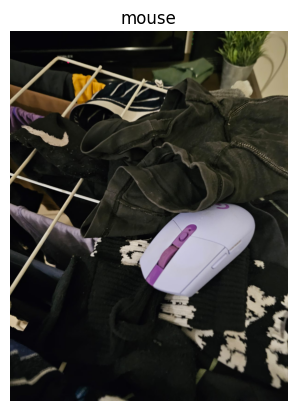

In [61]:
imgdir = "images_mouse_speaker/images_mouse_speaker/train"
img = show_image(imgdir, "mouse")

### preprocessing images

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_exercise = ImageDataGenerator(rescale=1/255,
                                      rotation_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True)

In [63]:
data_dir = "/content/images_mouse_speaker/images_mouse_speaker"

data_exercise_augmented = datagen_exercise.flow_from_directory(directory=data_dir,
                                                               target_size=(224, 224),
                                                               batch_size=32,
                                                               class_mode="binary")

Found 20 images belonging to 2 classes.
